This notebook was created by Josselin Deloste.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Collaborative Filtering in Recommender Systems</div>

Recommender systems are omnipresent in most of your everyday consulted websites. Indeed you all have been recommanded either a movie to watch (on Netflix, Amazon prime), a song to listen (on Deezer or Spotify), an item to buy (Ebay, Amazon), a person to follow (Instagram, Facebook, Twitter). All of these approaches are the results of recommander systems which have obvious applications when it comes to maximize customer satisfaction by improving the service quality, providing easier navigation and/or to increase advertising campaign returns. 


$\textbf{How do these companies do ?}$

They use various techniques combining different datasets which are : 
- pure user datasets - only user informations e.g : location, profession, age, passions, interests etc ...
- pure item datasets - only item informations e.g Movies : genre, year, actors, version etc ...
- user-item datasets - user-item informations e.g : ratings etc ... 
- mixed datasets - a mix of the foregoing

Recommender systems techniques relying only on user-item informations are known as $\textit{collaborative filtering}$ methods. The following course aims to present the latter algorithms and to explain how $\textit{collaborative filtering}$ approaches are used in recommender systems through easy examples. 

1. [Collaborative Filtering](#sec1)
2. [Pratical case Introduction - The movieLens dataset](#sec2)
3. [User based collaborative filtering](#sec3)
4. [Item based collaborative filtering](#sec4)
5. [Matrix factorization collaborative filtering](#sec5)

# 1. <a id="sec1"></a>Collaborative Filtering (CF)

**Idea:**



<img src="fig1.jpg" width="600px">  
Word-of-mouth has always been one of the most powerful marketing tool ! Have you liked something recently ? It is highly likely that someone who has liked similar items will appreciate it too or that you would like a similar product ! The problem remains to evaluate the "user-user or item-item similarity".

**Some notation:**
- $M$ : rating matrix $M:=[m_{ui}]_{u,i\in  [\![1,n]\!]^{2}}$ where $m_{ui}$ corresponds to the item $i$ rating given by user $u$

Typical rating matrix:
\begin{equation}
M \in \mathbb{R}^{m \times n} = \left [ \begin{array}{cccccccc}
0.5 & NaN & 2   & NaN & NaN & NaN & 5   & NaN \\
NaN & 4   & NaN & NaN & 0.5 & 3   & 2   & 1   \\
1   & 3   & 3   & NaN & NaN & 0.5 & 3   & 4   \\
4   & 5   & 2   & 4   & 2   & NaN & 2.5 & NaN \\
2   & NaN & 4   & 5   & 3.5 & NaN & NaN & 3   \\
NaN & 2   & 3.5 & 0.5 & 2   & 3   & 2   & NaN \\
3   & NaN & NaN & 5   & 4   & 0.5 & 3   & 4   \\
1.5 & NaN & NaN & 2   & 3   & NaN & NaN & NaN \\
NaN & 3   & 3   & NaN & 3.5 & NaN & 4   & 3   \\
NaN & 2.5 & NaN & 4   & 4   & 3   & NaN & NaN \\
\end{array} \right ]
\end{equation}

$\textit{Remark :}$ The rating matrix is a sparse matrix. Indeed in general by modifying our initial notation system, we can assume that unknown matrix entries are zeros (we just need not to allow 0 grades). 

In our example, $m:=10$ users have accepted to rate $n:=8$ items $\textit{e.g}$ in this matrix user 1 has given a 0.5 note to item 1 and a 5 note to item 7. 

Collaborative Filtering aims to fill in the matrix using only existing values: we want to replace all remaining unknown values by approximations based on the available rates and not user or item features. Thus, these approximations will correspond to our recommendations. 

# 2.<a id="sec2"></a> Our practise case : Would you like to update your old-fashined movie recommending system ?

$\textbf{History:}$ 

Historically collaborative filtering had been substantially developped during Netflix early years when the company released a fully open $USD 1 000 000 prize money competition. At the end of the competition Netflix improves its recommendation satisfactions by 10 %.

During this recommender system course we will study recommender algorithms through movie recommendations.

In [48]:
# importing needed libraries
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.stats as st

In [236]:
# Load our ratings data
ratings = pd.read_csv('./Movies_data/ratings.csv')

print(ratings.shape)
ratings.head()

(100234, 4)


,userId,movieId,rating,timestamp
0,1,1,5.0,847117005
1,1,2,3.0,847642142
2,1,10,3.0,847641896
3,1,32,4.0,847642008
4,1,34,4.0,847641956


In [237]:
#Load our movies data
movies = pd.read_csv('./Movies_data/movies.csv')

print(movies.shape)
movies.head()

(8927, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [474]:
# creating our rating matrix
M = ratings.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)
movie_Ids_columns = M.columns
M.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,132796,133419,133545,133897,134170,134368,134393,134783,134853,135887
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [475]:
M = np.array(M)

print('Number of lines (i.e total number of users) in the matrix M : '+str(M.shape[0]))
print('Number of columns (i.e total number of movies) in the matrix M : '+str(M.shape[1]))

Number of lines (i.e total number of users) in the matrix M : 718
Number of columns (i.e total number of movies) in the matrix M : 8915


In this example, zero values correspond to unknown ratings : it is not possible to provide a note smaller than 0.5. The rating range between 0.5 and 5.0. 

In [243]:
# print M sparsity percentage
print('The initial sparsity percentage of the M matrix is: '+str(sum(sum(M==0))/(M.shape[0]*M.shape[1])*100))

# Delete all movies for which we do not have any data and therefore which we would not be able to recommend
valid_movies = (M!=0).sum(axis=0) > 0 # we collect all movie indexes corresponding to movies rated at least once 
M = M[:,valid_movies]
print('The new matrix M shape is: ('+str(M.shape[0])+','+str(M.shape[1])+')')

# Exercice delete all users for who we do not have any data and therefore who will not be able to use the recommending service
valid_users = (M!=0).sum(axis=1)>0 
M = M[valid_users,:]        
print('The new matrix M shape is: ('+str(M.shape[0])+','+str(M.shape[1])+')')

print('The new sparsity percentage of the M matrix is: '+str(sum(sum(M==0))/(M.shape[0]*M.shape[1])*100))

The initial sparsity percentage of the M matrix is: 98.43408108458563
The new matrix M shape is: (718,8915)
The new matrix M shape is: (718,8915)
The new sparsity percentage of the M matrix is: 98.43408108458563


In [503]:
# Some basic statistics

# average rating given by each user
user_means = np.array([M[i,M[i,:]!=0].mean() for i in range(M.shape[0])])

# movie average rate 
movie_means = np.array([M[M[:,i]!=0,i].mean() for i in range(M.shape[1])])


Text(0,0.5,'Count')

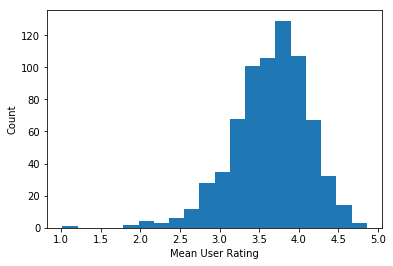

In [504]:
# User means histogram
plt.hist(user_means, bins=20)
plt.xlabel("Mean User Rating")
plt.ylabel("Count")

Text(0,0.5,'Count')

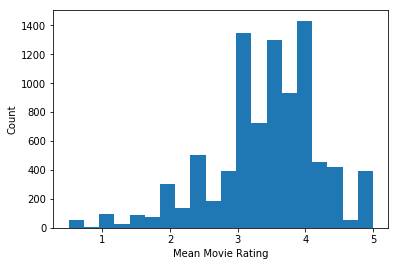

In [505]:
# Movie means histogram
plt.hist(movie_means, bins=20)
plt.xlabel("Mean Movie Rating")
plt.ylabel("Count")

Text(0,0.5,'Number of Movies')

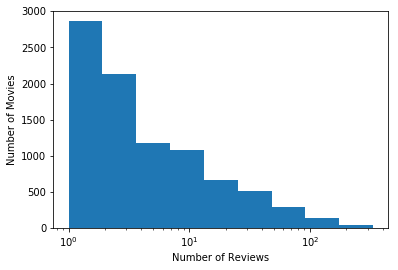

In [506]:
# Number of reviews per movie histogram
num_reviews = (M!=0).astype(float).sum(axis=0)
plt.hist(num_reviews,bins=np.logspace(np.log10(min(num_reviews)),np.log10(max(num_reviews)),10))
plt.gca().set_xscale("log")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Movies")

$\textbf{Note:}$ Using a first trivial approach, for each user we can already return the best rated movie which has not been watched yet. But let us personalize our recommendations.

# 3. <a id="sec3"></a> User-user collaborative filtering 

$\textbf{History:}$ 

User-user collaborative filtering also known as k-NN collaborative filtering was the first of the automated CF methods. 

<img src="user_user_approach.png" width="300px">  

** Idea:**
- The active user's preference can be predicted using other selected and aggregated users' opinions 

** Challenges:**

The collaborative filtering requires a similarity function $s :  U^{2} \rightarrow \mathbb{R}$ which will compute the similarity between two users. One idea is to use correlation coefficients or other similarity measurement coefficients. This solution raises several issues related to low level of available data : How to compute similarities when only a few common data are available ? 

** Computing predictions:**

In order to generate our predictions for a given user $u$ we first need to find a neighborhood $N \in U$. Then for all unrated items $i$ we need to compute user $u$ predictions. To do so a commonly used method consist in computing the weighted average : 

 <center> $\widehat{m}_{ui} := \overline{m_{u}} + \frac{\sum_{u_{n} \in N}s(u,u_{n})*(m_{u_{n},i}-\overline{m_{u_{n}}})}{\sum_{u_{n} \in N}|s(u,u_{n}|}$ 

with $s(.,.)$ the user similarity function, $N$ user $u$ neighbors, $\overline{m_{u}}$ the average rate given by user $u$ and $\widehat{m}_{ui}$ the estimated rating that user $u$ would give for item $i$ 

** Computing User Similarity:**

One critical design decision is to choose the appropriate similarity function.

Only the most common functions will be presented:


-** Person correlation:** We compute Person's statistical correlation between user's ratings.

<center>$s(u,u_{n}):= \frac{\sum_{i \in I_{u} \cap I_{u_{n}}}(m_{ui} - \overline{m_{u}})(m_{u_{n}i} - \overline{m_{u_{n}}})}{\sqrt{\sum_{i \in I_{u} \cap I_{u_{n}}}(m_{ui} - \overline{m_{u}})^{2}}\sqrt{\sum_{i \in I_{u} \cap I_{u_{n}}}(m_{u_{n}i} - \overline{m_{u_{n}}})^{2}}}$

In order to improve our similarity accuracy we can define a value number threshold under which the similarity function will not computed. Indeed in a two common values case the Person's correlation will exactly be either -1 or 1. In addition it is also possible to scale the similarity when the number of co-rated items falls below a defined threshold. To do so we simply multiply the similarity function by min{$\frac{|I_{u}\cap I_{u_{n}}|}{Threshold}$,1}.


-** Constrained Person correlation:** We compute a constrained Person's correlation between user's ratings.

Historically introduced by the singer Ringo who solicited ratings from its users on a 7-point scale : 1 hate, 7 love and 4 corresponds to a neutral value noted $m_{n}$ $\textit{i.e}$ the user neither like nor dislike. It is then possible to correlate absolute like/dislike rather than relative deviation as for the standard Person's correlation coefficient. 

<center> $s(u,u_{n}):= \frac{\sum_{i \in I_{u} \cap I_{u_{n}}}(m_{ui} - m_{n})(m_{u_{n}i} - m_{n})}{\sqrt{\sum_{i\in I_{u} \cap I_{u_{n}}(m_{ui} - m_{n})^{2}}}\sqrt{\sum_{i\in I_{u} \cap I_{u_{n}}(m_{u_{n}i} - m_{n})^{2}}}}$
    
    
-** Spearman rank correlation:** Computing Spearman's correlation. 

Same principle as for Person's correlation : we just use Spearman's rank correlation instead of Person's coefficient (by definition the Spearman coefficient is defined as the Person coefficient applied to rank variables).

<center> $s(u,u_{n}):= 1 - \frac{6\sum d_{u u_{n}i}^{2}}{n(n^{2}-1)}$ 
    
with $n := |I_{u}\cap I_{u_{n}}|$ and $d_{i}:= rank(m_{ui}) - rank(m_{u_{n}i})$
    
    
-** Cosine similarity:**  Computing cosine similarity. 

We now use a linear algebra based approach instead of a statistical approach : Users are represented as $|I|$-dimensional vectors and the similarity is measured by the cosine distance between two rating vectors.

<center>$s(u,u_{n}):= \frac{m_{u}.m_{u_{n}}}{||m_{u}||_{2}||m_{u_{n}}||_{2}} = \frac{\sum_{i}m_{ui}m_{u_{n}i}}{\sqrt{\sum_{i}m_{ui}^{2}}\sqrt{\sum_{i}m_{u_{n}i}^{2}}}$

<div class="alert alert-warning">**Exercice**<br>
Can you predict user rates ?

Given data :
<ul>
<li> Rating matrix : $M$
<li> User means : user_means
<li> Similarity matrix : $S$
<li> UserId : $u$
</ul>

In [ ]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

<div class="alert alert-warning">**Exercice**<br>
Can you generate the similarity matrix using the desired method (Person/Spearman correlations or Cosine similarity)?

Given data :
<ul>
<li> Rating matrix : $M$
<li> User means : user_means
<li> Common threshold : $common\_items\_threshold$ 
</ul>

In [252]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

<div class="alert alert-warning">**Exercice**<br>
Can you generate user 4 top 10 recommendations ?

Given data :
<ul>
<li> Rating matrix : $M$
<li> User means : user_means
<li> Similarity matrix : $S$ - compute it using your desired method $\textit{e.g}$ cosine similarity
</ul>

In [273]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# 4. <a id="sec4"></a> Item-Item collaborative filtering 

<img src="item_item_approach.png" width="300px">  

** Idea:**
- If one user has liked an item he/she will probably appreciate similar items.


** Computing neighborhood:**
In order to estimate user $u$ rating for item $i$, we use all other user $u$ ratings weighted by the similarity between the two items. Thus the recommender system remains unchanged excepted for the similarities which are now calculated using an item similarity function.

 <center> $\widehat{m}_{ui} := \overline{m_{i}} + \frac{\sum_{i_{n} \in N}s(i,i_{n})*(m_{ui_{n}}-\overline{m_{i_{n}}})}{\sum_{i_{n} \in N}|s(i,i_{n}|}$ 

with $s(.,.)$ the item similarity function, $\overline{m_{i}}$ the average rate given for item $i$ and $\widehat{m}_{ui}$ the estimated rating that user $u$ would give for item $i$ 

<div class="alert alert-warning">**Exercice**<br>
Can you predict movie rates?

Given data :
<ul>
<li> Rating matrix : $M$
<li> Movie means : item_means
<li> Similarity matrix : $S$
<li> MovieId : $i$
</ul>

In [ ]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

<div class="alert alert-warning">**Test**<br>
Generate item 10 rate predictions

Given data :
<ul>
<li> Rating matrix : $M$
<li> Movie means : movie_means
<li> Similarity matrix : $S$ - compute it using your desired method $\textit{e.g}$ cosine similarity
</ul>

In [ ]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

<div class="alert alert-warning">**Question**<br>
How would you realize user 4 top 10 recommendations ? 

<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse">**Ready to see the answer? (click to expand)**</a><br>
<div id="answer2" class="collapse">
To get a list of a user predictions, we need to iterate over all items $\textit{i.e}$ for the entire rating matrix $M$.
</div>
</div>

<div class="alert alert-warning">**Optional**<br>
Generate user 4 top 10 recommendations

In [471]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

** Conclusion:**

The recommendations are slightly differents. It would be interesting to know which one works varying the similarity function. For both approaches we do not scale particularly well massive datasets because of the rating matrix sparsity (computing time increases heavily $\textit{cf.}$ item-item approach for which we had to realize all possible predictions). In addition when we match to sparse low-level details we assume that the user's preference is well represented which may be false (if one user has listened a dozen of Eminem songs and another has listened a dozen different ones they will have nothing in common even if it seems pretty obvious they share preferences). Finally neighbors are not independent at all, so using a standard similarity metric to define a weighted mean overcounts information $\textit{e.g}$ if both users have watched Harry Potter movies we will count 8 times the same information. 

# 5. <a id="sec5"></a> Matrix factorization collaborative filtering (Singular Value Decomposition)

**How can we resolve previous challenges ?** 

One solution is to derive users' tastes and preferences directly from the data. By using the Matrix factorization collaborative filtering which fits better into the machine learning framework and does not rely on the idea of "nearness" we will "learn" users' tastes. 

** Idea:**
-  
Matrix factorization is the breaking down of one matrix in a product of multiple matrices. The goal is to learn the  users' preferences and items' attributes from known ratings in order to predict all missing ratings. In orther words we want to find a smaller number of dimensions, ideally a constant number so that items and users can be represented by $k$-dimensional vectors.

**Advantages:**

By doing a matrix factorization we rebuild our rating matrix in a lower-rank one which saves memory space(In general rating matrices are large sparse matrices). In addition in this case we will be able to generate recommendations for new users who have not rated any movie.

**Singular Value Decomposition example:**

To start with the easiest matrix factorization may be singular value decomposition - SVD : it decomposes a matrix $M$ into the best lower rank approximation matrix. 

<center> $ M = U \Sigma T^{T}$
    
with $U$ and $T^{T}$ othogonal matrices and $\Sigma$ the singular value matrix. $\Sigma$ represents the movie features matrix, U represents the user feature preferences and $T^{T}$ the movie feature relevancies. 

<img src="fig2.png" width="300px">  


**Dimension reduction:**

In order to reduce the approximation rank, we want to keep only the top features which underly users' tastes and preferences. In pratice one way to do so is to select a reasonable number of features that will be used and then to minimize the Root-mean-square error RMSE. That's equivalent of resolving a classical optimization algorithms finding the best lower approximation possible.

With SVD decomposition we just have to choose the desired number of features $k$ and it gives directly the corresponding decomposition. Indeed first we realize a non-reduced SVD decomposition (possible for all matrices) and then select the $k$ highest singular values and dump the others. 

**Computing predictions:**

Once the SVD reduction is computed the predicted preference or rating of user $u$ for movie/item $i$ can be computed as the dot product of the user interest vector $\textbf{u}$ and the movie/topic relevance vector $t$:

<center> $\widehat{m_{ui}} = \sum_{f}u_{f}d_{f}t_{f}$

$d_{f}$ represents the movie feature importances obtained thanks the singular value $D$. Indeed with a SVD decomposition we generate our predictions using a weighted dot product.

$\textit{Remark:}$ The matrix factorization for collaborative filtering is quite close from the Principal component analysis decomposition (PCA) used in unsupervized learning. In both case we want to find a matrix low-rank approximation. However while with PCA we try to find an approximation that matches all $M$ entries with matrix factorization for CF we only consider observed entry losses. 

<div class="alert alert-warning">**Question**<br>
Generate all predicted rating using SVD matrix factorization

$\textbf{Help:}$ see svds notice

In [580]:
# %load solutions/code7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

In [570]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df[user_row_number].sort_values(ascending=False) # UserID starts at 1
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    temp = pd.DataFrame(sorted_user_predictions).reset_index()
    temp.columns = ['movieId','rating']
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(temp, how = 'left',left_on = 'movieId',right_on = 'movieId').rename(columns = {user_row_number: 'predictions'}).
         sort_values('rating', ascending = False).iloc[:num_recommendations, :-1])
    print('User '+str(userID)+' has already rated '+ str(user_full.shape[0]) +' movies')
    print('Recommending highest '+str(num_recommendations) + ' predicted ratings movies not already rated :')
    return user_full, recommendations

In [574]:
# Generate user 4  top 10 recommendations
already_rated,recommendations = recommend_movies(preds,4,movies,ratings,10)
recommendations

User 4 has already rated 24 movies
Recommending highest 10 predicted ratings movies not already rated :


,movieId,title,genres
54,61,Eye for an Eye (1996),Drama|Thriller
397,454,Firm The (1993),Drama|Thriller
381,437,Cops and Robbersons (1994),Comedy
90,102,Mr. Wrong (1996),Comedy
159,185,Net The (1995),Action|Crime|Thriller
214,246,Hoop Dreams (1994),Documentary
113,129,Pie in the Sky (1996),Comedy|Romance
162,188,Prophecy The (1995),Fantasy|Horror|Mystery
107,122,Boomerang (1992),Comedy|Romance
64,71,Fair Game (1995),Action


**Non-Negative Matrix Factorization example**

Another MF commonly used is the non-negative matrix factorization : we approximate the non negative rating matrix M as a product of two non negative lower rank matrices. 

$\textit{Remark:} We can assume M is positive with no loss of generality as the rating scale can be defined in order not to have negative rates.

<center> $M = UT^{T}$
    
The $U$ & $T^{T}$ matrices' interpretentation remain unchanged : U represents the user feature preferences and T the movie feature relevancies.

<img src="fig3.png" width="400px"> 

**Dimension reduction:**

As explained previously, in order to reduce the matrix dimensions we choose a desired number of features $k$ and then minimize the squared loss function

<center> $minimize_{u_{1:m},t_{1:n}} \sum_{ui \in S} (u_{u}t^{T}_{i} - M_{ui})^{2}$

To solve this optimization problem, a common practice is to use the $\textit{alternating least squares algorithm}$ or $\textit{gradient descent algorithm}$. 

$\textit{Remark:}$ 
If we do not want to define a number of features $k$ we can minimize a slightly modified loss function : 
<center> $minimize_{u_{1:m},t_{1:n}} \sum_{ui \in S} (u_{u}t^{T}_{i} - M_{ui})^{2} + \lambda (||u_{u}||_{1} + ||t_{i}||_{1})$

$\lambda (||u_{u}||_{1} + ||t_{i}||_{1})$ represents the regularization term. As we have seen during the unsupervized learning courses the convex hull of the counting function is exactly the $||.||_{1}$ norm. 

** Computing predictions:**

The prediction $\widehat{mui}$ is once more given by :

<center>  $\widehat{m_{ui}}= u_{u}t_{i}^{T}$
    



<div class="alert alert-warning">**Question**<br>
- Generate all predicted rating using Non-Negative Matrix Factorization (NMF)
- Generate user 4  top 10 recommendations


$\textbf{Help:}$ see NMF notice

In [575]:
from sklearn.decomposition import NMF

# %load solutions/code8.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).